# GPU

In [ ]:
# The GPU provided has 12GB of memory. However, sometimes the memory of your GPU is shared with other users. At that situation you won’t be able to train your model properly. 
# To make sure that the current GPU memory utilization is 0, run the code below:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1933ed741549cc93495222025120a22c30f810c78fcc5939049653bad015edf5
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


IndexError: ignored

In [ ]:
# If the utilization is greater than 0% try to kill your machine, using the code below. This might not work on your first attempt and you can try this multiple times.

!kill -9 -1

In [ ]:
# Updating your data
# Once your Drive is mounted, any change to your drive directory (editing code, adding files, etc.) will not be encountered by Colab. This is due to Colab caching mechanism. 
# To overcome this, you should clear the cache before using your new files, using:

!google-drive-ocamlfuse -cc

/bin/bash: google-drive-ocamlfuse: command not found


# LRFinder definition

code source: https://github.com/titu1994/keras-one-cycle

In [ ]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = batch_size
        self.samples = num_samples
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = self.params['epochs']
        # When fit generator is used
        # self.params don't have the elements 'batch_size' and 'samples'
        # self.batch_size = self.params['batch_size']
        # self.samples = self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))


class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

# Imports & data

In [ ]:
import os
import time
import cv2 as cv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import EfficientNetB4, DenseNet201, EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras import layers
#from keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import argmax
from tensorflow.keras.optimizers import Adam
from keras import backend as K

from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score, accuracy_score, log_loss, brier_score_loss
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 1


In [ ]:
def load_from_dir(dir, dir_cat, data):
    for file in os.listdir(dir):
        if not file.endswith(".jpg"):
            continue

        filename = os.path.join(dir, file)
        category = dir_cat

        data['filename'].append(filename)
        data['category'].append(category)

In [ ]:
def read_data():
    data = {
        'filename': [],
        'category': []
    }

    dirs = ["low_Rp", "high_Rp"]
    for i, drc in enumerate(dirs):
        dir_path = os.path.join(DATA_DIR, drc)
        load_from_dir(dir_path, i, data)
            
    df = pd.DataFrame(data)

    X = []
    y = []
    for _, data in df.iterrows():
        img = cv.imread(data.filename)
        X.append(img)
        y.append(data.category)
    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = 'drive/MyDrive/mgr/data/Rp/proc_data_500x_without_scale_224_374'

In [ ]:
def get_recall(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positive
    PP = K.sum(K.round(K.clip(y_true, 0, 1))) # possible positives
    recall = TP / (PP + K.epsilon())
    
    return recall

def get_precision(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    PP = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
    precision = TP / (PP + K.epsilon())
    
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    return f1_score

In [ ]:
with tf.device("/device:GPU:0"):
  X, y = read_data()

In [ ]:
X.shape #1676

(1676, 224, 374, 3)

In [ ]:
def predict_prob(y_pred_p):
  pred_prob = []
  for y in y_pred:
    pred_prob.append([1-y,y])

  return pred_prob

In [ ]:
def print_metrics(y_true, y_pred, y_proba):
  print("AP micro: ", average_precision_score(y_test, y_pred, average='micro')) 
  print("AP macro: ", average_precision_score(y_test, y_pred, average='macro'), '\n') 

  print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
  print("f1 macro: ", f1_score(y_test, y_pred, average='macro')) 
  print("f1 binary: ", f1_score(y_test, y_pred, average='binary'), '\n') 

  print("precision micro: ", precision_score(y_test, y_pred, average='micro')) 
  print("precision macro: ", precision_score(y_test, y_pred, average='macro')) 
  print("precision binary: ", precision_score(y_test, y_pred, average='binary'), '\n') 

  print("recall micro: ", recall_score(y_test, y_pred, average='micro')) 
  print("recall macro: ", recall_score(y_test, y_pred, average='macro')) 
  print("recall binary: ", recall_score(y_test, y_pred, average='binary'), '\n') 

  print("accuracy: ", accuracy_score(y_test, y_pred)) 
  print("log_loss: ", log_loss(y_test, y_pred_p)) 
  print("brier_score_loss: ", brier_score_loss(y_test, y_pred)) 
  

# EfficientNet-B4

## Find optimal learning rate

In [ ]:
# bez danych walidacyjnych:
with tf.device("/device:GPU:0"):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-6, maximum_lr=1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
  #history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=1, batch_size=bs, validation_data=(X_test, to_categorical(y_test, num_classes=2)), callbacks=[lr_finder])
  history = model.fit(X_train, y_train, epochs=1, batch_size=bs, callbacks=[lr_finder])


In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2.98)

In [ ]:
pow(10,-2) #0.000 001

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

## lr=0.01 - binary

In [ ]:
learning_rate = 0.01
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1792)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=8, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/8
93/93 [==============================] - 50s 378ms/step - loss: 1.8143 - get_f1: 0.7603 - val_loss: 2.0904 - val_get_f1: 0.8369
Epoch 2/8
93/93 [==============================] - 32s 343ms/step - loss: 1.4731 - get_f1: 0.7959 - val_loss: 0.8367 - val_get_f1: 0.7531
Epoch 3/8
93/93 [==============================] - 32s 340ms/step - loss: 1.2947 - get_f1: 0.8163 - val_loss: 0.7021 - val_get_f1: 0.9003
Epoch 4/8
93/93 [==============================] - 32s 343ms/step - loss: 1.2562 - get_f1: 0.8296 - val_loss: 0.6128 - val_get_f1: 0.9115
Epoch 5/8
93/93 [==============================] - 32s 341ms/step - loss: 1.3504 - get_f1: 0.8256 - val_loss: 1.1339 - val_get_f1: 0.8843
Epoch 6/8
93/93 [==============================] - 32s 341ms/step - loss: 1.5322 - get_f1: 0.8183 - val_loss: 1.0813 - val_get_f1: 0.7036
Epoch 7/8
93/93 [==============================] - 32s 341ms/step - loss: 1.3717 - get_f1: 0.8252 - val_loss: 0.9630 - val_get_f1: 0.9020
Epoch 8/8
93/93 [=================

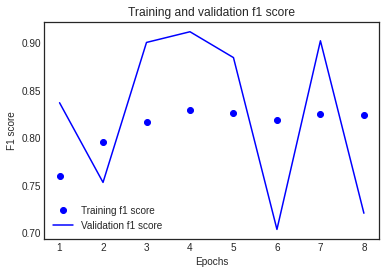

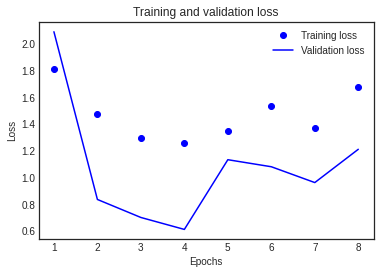

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 1792)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=4, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/4
124/124 [==============================] - 47s 260ms/step - loss: 1.8629 - get_f1: 0.7686
Epoch 2/4
124/124 [==============================] - 32s 259ms/step - loss: 1.1099 - get_f1: 0.8335
Epoch 3/4
124/124 [==============================] - 32s 256ms/step - loss: 1.6211 - get_f1: 0.8000
Epoch 4/4
124/124 [==============================] - 32s 258ms/step - loss: 1.3451 - get_f1: 0.8243
Training time: 158.46983575820923s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

124/124 [==============================] - 34s 256ms/step - loss: 0.6831 - get_f1: 0.8973
train:  [0.6831241250038147, 0.8972991108894348]
31/31 [==============================] - 8s 251ms/step - loss: 0.7389 - get_f1: 0.9044
test:  [0.7389488220214844, 0.9044345617294312]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.8389815838239907
AP macro:  0.8389815838239907 

f1 micro:  0.8565656565656565
f1 macro:  0.8013329263329263
f1 binary:  0.906084656084656 

precision micro:  0.8565656565656565
precision macro:  0.8838298525798526
precision binary:  0.8415233415233415 

recall micro:  0.8565656565656565
recall macro:  0.7697972681241905
recall binary:  0.9813753581661891 

accuracy:  0.8565656565656565
log_loss:  nan
brier_score_loss:  0.14343434343434344


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.56      0.70       292
           1       0.84      0.98      0.91       698

    accuracy                           0.86       990
   macro avg       0.88      0.77      0.80       990
weighted avg       0.87      0.86      0.84       990



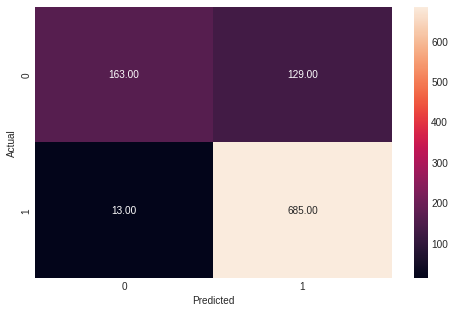

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 - SELECTED

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

71696384/71686520 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d (Globa  (None, 1792)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 48s 494ms/step - loss: 1.4873 - get_f1: 0.3746 - val_loss: 0.7214 - val_get_f1: 0.4527
Epoch 2/10
32/32 [==============================] - 11s 333ms/step - loss: 1.2461 - get_f1: 0.4648 - val_loss: 0.7890 - val_get_f1: 0.2707
Epoch 3/10
32/32 [==============================] - 10s 330ms/step - loss: 1.2236 - get_f1: 0.4715 - val_loss: 0.7143 - val_get_f1: 0.4215
Epoch 4/10
32/32 [==============================] - 10s 328ms/step - loss: 1.2694 - get_f1: 0.4667 - val_loss: 0.7676 - val_get_f1: 0.3260
Epoch 5/10
32/32 [==============================] - 10s 327ms/step - loss: 1.1497 - get_f1: 0.4593 - val_loss: 0.6981 - val_get_f1: 0.4473
Epoch 6/10
32/32 [==============================] - 10s 327ms/step - loss: 1.1330 - get_f1: 0.4669 - val_loss: 0.6650 - val_get_f1: 0.4871
Epoch 7/10
32/32 [==============================] - 10s 327ms/step - loss: 1.0494 - get_f1: 0.4451 - val_loss: 0.6813 - val_get_f1: 0.5223
Epoch 8/10
32/32 [=========

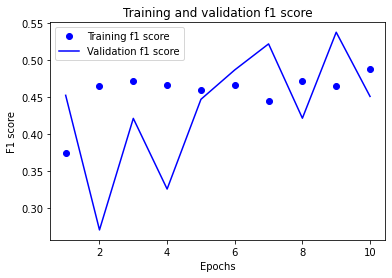

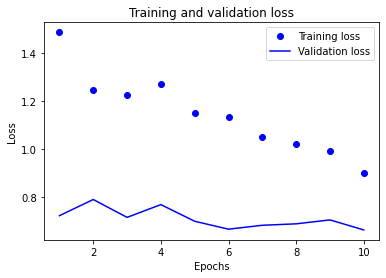

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d (Globa  (None, 1792)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=6, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/6
42/42 [==============================] - 31s 288ms/step - loss: 1.4836 - get_f1: 0.3788
Epoch 2/6
42/42 [==============================] - 11s 254ms/step - loss: 1.2972 - get_f1: 0.4328
Epoch 3/6
42/42 [==============================] - 11s 255ms/step - loss: 1.2008 - get_f1: 0.4153
Epoch 4/6
42/42 [==============================] - 11s 251ms/step - loss: 1.1806 - get_f1: 0.4457
Epoch 5/6
42/42 [==============================] - 10s 249ms/step - loss: 1.0980 - get_f1: 0.4508
Epoch 6/6
42/42 [==============================] - 10s 249ms/step - loss: 1.0815 - get_f1: 0.4105
Training time: 83.87110352516174s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 15s 253ms/step - loss: 0.6793 - get_f1: 0.6113
train:  [0.679347813129425, 0.6113075017929077]
11/11 [==============================] - 3s 237ms/step - loss: 0.7115 - get_f1: 0.5996
test:  [0.711483895778656, 0.5996252298355103]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4795171716419762
AP macro:  0.4795171716419762 

f1 micro:  0.6101190476190477
f1 macro:  0.6101155941361442
f1 binary:  0.6089552238805971 

precision micro:  0.6101190476190477
precision macro:  0.6368036057337076
precision binary:  0.504950495049505 

recall micro:  0.6101190476190477
recall macro:  0.6371532278973295
recall binary:  0.7669172932330827 

accuracy:  0.6101190476190477
log_loss:  0.7114839063114708
brier_score_loss:  0.3898809523809524


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.51      0.61       203
           1       0.50      0.77      0.61       133

    accuracy                           0.61       336
   macro avg       0.64      0.64      0.61       336
weighted avg       0.66      0.61      0.61       336



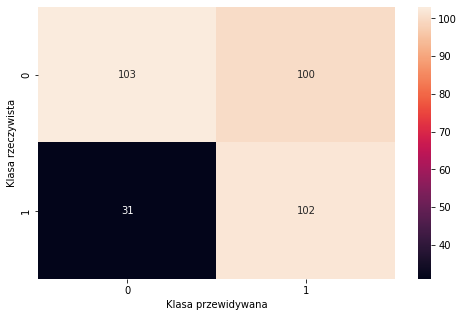

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
model.save('drive/MyDrive/mgr/saved_models/7m_en4_img_imbalanced_rp')

In [ ]:
test_model = models.load_model('drive/MyDrive/mgr/saved_models/5m_dn201_img_imbalanced_rp', custom_objects={"get_f1": get_f1})

## lr=0.001 & do=0.2

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 35s 478ms/step - loss: 1.1532 - get_f1: 0.3703 - val_loss: 0.7352 - val_get_f1: 0.2713
Epoch 2/10
32/32 [==============================] - 11s 339ms/step - loss: 0.9299 - get_f1: 0.4256 - val_loss: 0.9758 - val_get_f1: 0.5774
Epoch 3/10
32/32 [==============================] - 10s 330ms/step - loss: 0.8466 - get_f1: 0.4983 - val_loss: 0.6546 - val_get_f1: 0.4864
Epoch 4/10
32/32 [==============================] - 10s 328ms/step - loss: 0.8547 - get_f1: 0.4672 - val_loss: 0.8467 - val_get_f1: 0.5699
Epoch 5/10
32/32 [==============================] - 10s 326ms/step - loss: 0.8403 - get_f1: 0.4796 - val_loss: 0.6623 - val_get_f1: 0.3992
Epoch 6/10
32/32 [==============================] - 10s 327ms/step - loss: 0.8234 - get_f1: 0.4743 - val_loss: 0.7326 - val_get_f1: 0.5659
Epoch 7/10
32/32 [==============================] - 10s 327ms/step - loss: 0.8448 - get_f1: 0.4711 - val_loss: 0.7353 - val_get_f1: 0.5656
Epoch 8/10
32/32 [=========

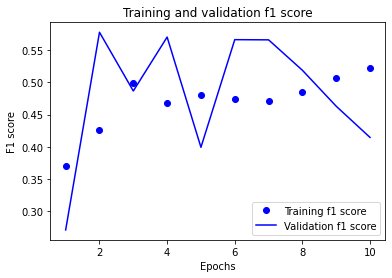

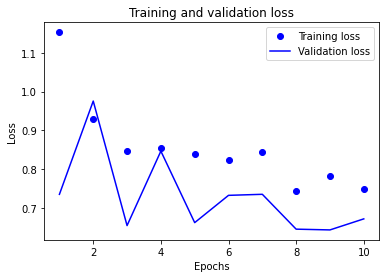

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1792)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=3, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
42/42 [==============================] - 31s 261ms/step - loss: 1.0436 - get_f1: 0.3856
Epoch 2/3
42/42 [==============================] - 11s 257ms/step - loss: 0.9295 - get_f1: 0.4020
Epoch 3/3
42/42 [==============================] - 11s 253ms/step - loss: 0.9132 - get_f1: 0.4448
Training time: 61.72382473945618s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.420609948785006
AP macro:  0.420609948785006 

f1 micro:  0.6011904761904762
f1 macro:  0.5257636401938065
f1 binary:  0.33663366336633654 

precision micro:  0.6011904761904762
precision macro:  0.5609835531672366
precision binary:  0.4927536231884058 

recall micro:  0.6011904761904762
recall macro:  0.5416126523204563
recall binary:  0.2556390977443609 

accuracy:  0.6011904761904762
log_loss:  0.695843485355865
brier_score_loss:  0.39880952380952384


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.83      0.71       203
           1       0.49      0.26      0.34       133

    accuracy                           0.60       336
   macro avg       0.56      0.54      0.53       336
weighted avg       0.58      0.60      0.57       336



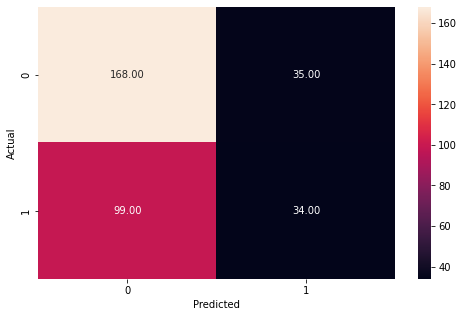

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# DenseNet201

## Find optimal learning rate

In [ ]:
# bez danych walidacyjnych:
#with tf.device("/device:GPU:0"):
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-6, maximum_lr=1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
    #history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=1, batch_size=bs, validation_data=(X_test, to_categorical(y_test, num_classes=2)), callbacks=[lr_finder])
  history = model.fit(X_train, y_train, epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00000140 
42/42 [==============================] - 42s 328ms/step - loss: 10.3637 - get_f1: 0.4089


In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

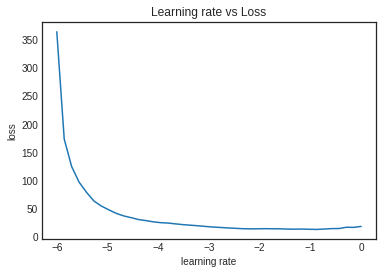

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2.98)

0.0010471285480508996

In [ ]:
pow(10,-2) #0.000 001

0.01

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

11/11 [==============================] - 8s 562ms/step - loss: 13.8824 - get_f1: 0.6064
loss : 13.8824
get_f1 : 0.6064


## lr=0.001 - SELECTED

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 27s 404ms/step - loss: 2.8971 - get_f1: 0.4032 - val_loss: 1.1112 - val_get_f1: 0.4911
Epoch 2/10
32/32 [==============================] - 9s 287ms/step - loss: 2.0249 - get_f1: 0.4893 - val_loss: 0.9872 - val_get_f1: 0.4655
Epoch 3/10
32/32 [==============================] - 10s 300ms/step - loss: 1.7198 - get_f1: 0.5123 - val_loss: 0.9320 - val_get_f1: 0.3956
Epoch 4/10
32/32 [==============================] - 9s 291ms/step - loss: 1.6557 - get_f1: 0.4616 - val_loss: 0.8425 - val_get_f1: 0.5901
Epoch 5/10
32/32 [==============================] - 9s 295ms/step - loss: 1.3254 - get_f1: 0.5311 - val_loss: 0.8040 - val_get_f1: 0.6113
Epoch 6/10
32/32 [==============================] - 9s 297ms/step - loss: 1.2288 - get_f1: 0.4962 - val_loss: 0.6551 - val_get_f1: 0.6222
Epoch 7/10
32/32 [==============================] - 10s 309ms/step - loss: 1.1191 - get_f1: 0.5133 - val_loss: 0.6336 - val_get_f1: 0.5462
Epoch 8/10
32/32 [=============

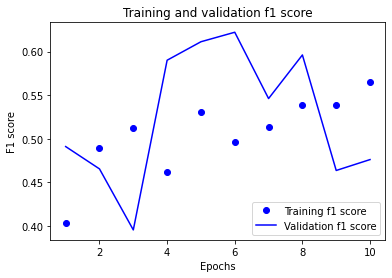

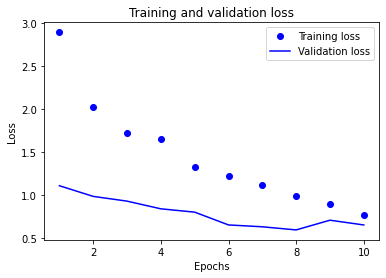

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d (Globa  (None, 1920)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=8, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/8
42/42 [==============================] - 35s 328ms/step - loss: 3.1147 - get_f1: 0.3824
Epoch 2/8
42/42 [==============================] - 9s 224ms/step - loss: 2.1615 - get_f1: 0.4568
Epoch 3/8
42/42 [==============================] - 10s 226ms/step - loss: 1.5802 - get_f1: 0.4770
Epoch 4/8
42/42 [==============================] - 10s 229ms/step - loss: 1.3806 - get_f1: 0.4678
Epoch 5/8
42/42 [==============================] - 10s 230ms/step - loss: 1.1130 - get_f1: 0.4711
Epoch 6/8
42/42 [==============================] - 10s 228ms/step - loss: 0.9257 - get_f1: 0.5232
Epoch 7/8
42/42 [==============================] - 9s 225ms/step - loss: 0.8416 - get_f1: 0.5443
Epoch 8/8
42/42 [==============================] - 10s 229ms/step - loss: 0.7301 - get_f1: 0.5786
Training time: 102.07371425628662s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 13s 227ms/step - loss: 0.5078 - get_f1: 0.6701
train:  [0.5077826976776123, 0.6701030731201172]
11/11 [==============================] - 2s 219ms/step - loss: 0.5835 - get_f1: 0.6219
test:  [0.5834670662879944, 0.6219282746315002]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.5509679370840895
AP macro:  0.5509679370840895 

f1 micro:  0.7172619047619048
f1 macro:  0.6969438035831268
f1 binary:  0.6184738955823293 

precision micro:  0.7172619047619048
precision macro:  0.7046238244514107
precision binary:  0.6637931034482759 

recall micro:  0.7172619047619048
recall macro:  0.6934145709100337
recall binary:  0.5789473684210527 

accuracy:  0.7172619047619048
log_loss:  0.5834670346978653
brier_score_loss:  0.28273809523809523


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       203
           1       0.66      0.58      0.62       133

    accuracy                           0.72       336
   macro avg       0.70      0.69      0.70       336
weighted avg       0.71      0.72      0.71       336



In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
model.save('drive/MyDrive/mgr/saved_models/5m_dn201_img_imbalanced_rp')

In [ ]:
test_model = models.load_model('drive/MyDrive/mgr/saved_models/5m_dn201_img_imbalanced_rp', custom_objects={"get_f1": get_f1})

In [ ]:
print(classification_report(y_test, test_model.predict(X_test)>=0.5))


              precision    recall  f1-score   support

           0       0.75      0.81      0.78       203
           1       0.66      0.58      0.62       133

    accuracy                           0.72       336
   macro avg       0.70      0.69      0.70       336
weighted avg       0.71      0.72      0.71       336



## lr=0.001 & do=0.2

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

74850304/74836368 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 36s 630ms/step - loss: 1.6360 - get_f1: 0.4514 - val_loss: 0.8938 - val_get_f1: 0.3779
Epoch 2/10
32/32 [==============================] - 9s 298ms/step - loss: 1.4183 - get_f1: 0.4235 - val_loss: 1.0318 - val_get_f1: 0.5661
Epoch 3/10
32/32 [==============================] - 9s 291ms/step - loss: 1.2970 - get_f1: 0.4689 - val_loss: 0.7916 - val_get_f1: 0.5736
Epoch 4/10
32/32 [==============================] - 9s 296ms/step - loss: 1.0929 - get_f1: 0.5178 - val_loss: 0.7763 - val_get_f1: 0.5653
Epoch 5/10
32/32 [==============================] - 9s 297ms/step - loss: 1.0308 - get_f1: 0.5228 - val_loss: 0.7016 - val_get_f1: 0.5564
Epoch 6/10
32/32 [==============================] - 10s 302ms/step - loss: 0.9008 - get_f1: 0.5440 - val_loss: 0.6206 - val_get_f1: 0.5900
Epoch 7/10
32/32 [==============================] - 10s 303ms/step - loss: 0.8649 - get_f1: 0.5510 - val_loss: 0.7531 - val_get_f1: 0.5920
Epoch 8/10
32/32 [=============

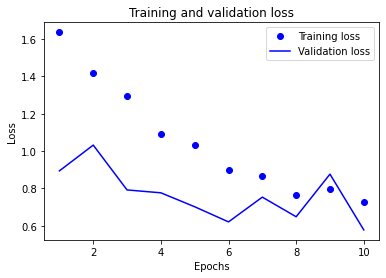

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=6, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/6
42/42 [==============================] - 30s 337ms/step - loss: 1.7884 - get_f1: 0.4241
Epoch 2/6
42/42 [==============================] - 9s 218ms/step - loss: 1.3685 - get_f1: 0.4463
Epoch 3/6
42/42 [==============================] - 9s 221ms/step - loss: 1.3718 - get_f1: 0.4546
Epoch 4/6
42/42 [==============================] - 9s 223ms/step - loss: 1.1627 - get_f1: 0.4867
Epoch 5/6
42/42 [==============================] - 9s 223ms/step - loss: 1.0274 - get_f1: 0.4969
Epoch 6/6
42/42 [==============================] - 9s 224ms/step - loss: 0.8482 - get_f1: 0.5249
Training time: 98.12802195549011s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.5277777777777777
AP macro:  0.5277777777777777 

f1 micro:  0.7023809523809523
f1 macro:  0.6571848345100599
f1 binary:  0.5327102803738317 

precision micro:  0.7023809523809523
precision macro:  0.7028322440087146
precision binary:  0.7037037037037037 

recall micro:  0.7023809523809523
recall macro:  0.6551724137931034
recall binary:  0.42857142857142855 

accuracy:  0.7023809523809523
log_loss:  0.6483313435691387
brier_score_loss:  0.2976190476190476


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       203
           1       0.70      0.43      0.53       133

    accuracy                           0.70       336
   macro avg       0.70      0.66      0.66       336
weighted avg       0.70      0.70      0.68       336



In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.0001

In [ ]:
learning_rate = 0.0001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 1920)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=13, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/13
32/32 [==============================] - 22s 387ms/step - loss: 2.6870 - get_f1: 0.4322 - val_loss: 1.2894 - val_get_f1: 0.3509
Epoch 2/13
32/32 [==============================] - 10s 303ms/step - loss: 2.6511 - get_f1: 0.4121 - val_loss: 1.2767 - val_get_f1: 0.3442
Epoch 3/13
32/32 [==============================] - 10s 307ms/step - loss: 2.3858 - get_f1: 0.4394 - val_loss: 1.1546 - val_get_f1: 0.4065
Epoch 4/13
32/32 [==============================] - 10s 310ms/step - loss: 2.3778 - get_f1: 0.4489 - val_loss: 1.1417 - val_get_f1: 0.4179
Epoch 5/13
32/32 [==============================] - 10s 306ms/step - loss: 2.5096 - get_f1: 0.4413 - val_loss: 1.1085 - val_get_f1: 0.4294
Epoch 6/13
32/32 [==============================] - 10s 302ms/step - loss: 2.4652 - get_f1: 0.4183 - val_loss: 1.0592 - val_get_f1: 0.4694
Epoch 7/13
32/32 [==============================] - 10s 303ms/step - loss: 2.5642 - get_f1: 0.4125 - val_loss: 1.0588 - val_get_f1: 0.4294
Epoch 8/13
32/32 [=========

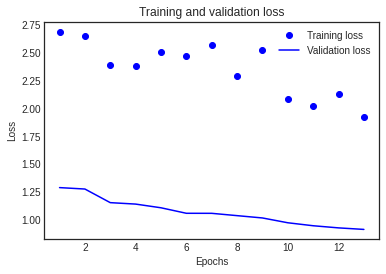

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_6 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=13, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/13
42/42 [==============================] - 18s 225ms/step - loss: 3.4044 - get_f1: 0.4114
Epoch 2/13
42/42 [==============================] - 10s 229ms/step - loss: 3.0617 - get_f1: 0.3671
Epoch 3/13
42/42 [==============================] - 10s 232ms/step - loss: 2.6958 - get_f1: 0.3640
Epoch 4/13
42/42 [==============================] - 10s 234ms/step - loss: 2.7464 - get_f1: 0.3805
Epoch 5/13
42/42 [==============================] - 10s 231ms/step - loss: 2.5185 - get_f1: 0.4004
Epoch 6/13
42/42 [==============================] - 10s 229ms/step - loss: 2.4139 - get_f1: 0.3976
Epoch 7/13
42/42 [==============================] - 10s 227ms/step - loss: 2.5242 - get_f1: 0.3946
Epoch 8/13
42/42 [==============================] - 10s 226ms/step - loss: 2.3553 - get_f1: 0.4218
Epoch 9/13
42/42 [==============================] - 10s 227ms/step - loss: 2.2327 - get_f1: 0.4197
Epoch 10/13
42/42 [==============================] - 10s 234ms/step - loss: 2.0211 - get_f1: 0.4525
Epoch 11/

In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 12s 223ms/step - loss: 0.8962 - get_f1: 0.4459
train:  [0.8961581587791443, 0.445908784866333]
11/11 [==============================] - 2s 215ms/step - loss: 0.8969 - get_f1: 0.4889
test:  [0.8969020843505859, 0.4889098107814789]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.48886328725038397
AP macro:  0.48886328725038397 

f1 micro:  0.6666666666666666
f1 macro:  0.6266518512639391
f1 binary:  0.504424778761062 

precision micro:  0.6666666666666666
precision macro:  0.6500730120801805
precision binary:  0.6129032258064516 

recall micro:  0.6666666666666666
recall macro:  0.625615763546798
recall binary:  0.42857142857142855 

accuracy:  0.6666666666666666
log_loss:  0.8969020602905532
brier_score_loss:  0.3333333333333333


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       203
           1       0.61      0.43      0.50       133

    accuracy                           0.67       336
   macro avg       0.65      0.63      0.63       336
weighted avg       0.66      0.67      0.65       336



In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# EfficientNet-B0

## Find optimal learning rate

In [ ]:
# bez danych walidacyjnych:
with tf.device("/device:GPU:0"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-4, maximum_lr=1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=1, batch_size=bs, validation_data=(X_test, y_test), callbacks=[lr_finder])
    #history = model.fit(X_train, y_train, epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00012519 
42/42 [==============================] - 26s 194ms/step - loss: 7.5572 - get_f1: 0.3376 - val_loss: 86.0342 - val_get_f1: 0.5660


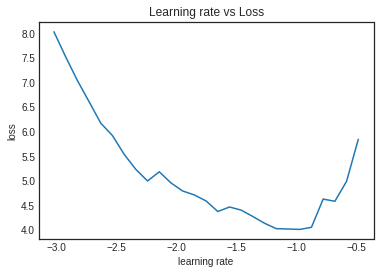

In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2.5)

0.0031622776601683794

In [ ]:
pow(10,-3.5) #0.000 001

0.00031622776601683794

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

11/11 [==============================] - 1s 96ms/step - loss: 86.0342 - get_f1: 0.5660
loss : 86.0342
get_f1 : 0.5660


## Find optimal learning rate - do=0.2

In [ ]:
# bez danych walidacyjnych:
with tf.device("/device:GPU:0"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-4, maximum_lr=1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=1, batch_size=bs, validation_data=(X_test, y_test), callbacks=[lr_finder])
    #history = model.fit(X_train, y_train, epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00012519 
42/42 [==============================] - 25s 186ms/step - loss: 5.0629 - get_f1: 0.3345 - val_loss: 26.2495 - val_get_f1: 0.3356


In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

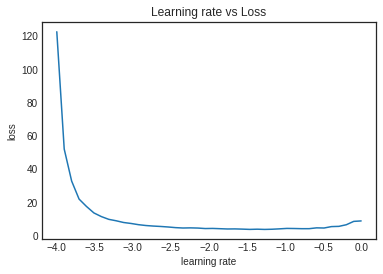

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2.5)

0.0031622776601683794

In [ ]:
pow(10,-3.5) #0.000 001

0.00031622776601683794

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

11/11 [==============================] - 1s 96ms/step - loss: 26.2495 - get_f1: 0.3356
loss : 26.2495
get_f1 : 0.3356


## lr=0.01 - NIE

In [ ]:
learning_rate = 0.01
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_15 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_15 (Dropout)        (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 12s 177ms/step - loss: 1.9873 - get_f1: 0.4134 - val_loss: 0.9865 - val_get_f1: 0.5335
Epoch 2/10
32/32 [==============================] - 4s 132ms/step - loss: 1.7599 - get_f1: 0.4405 - val_loss: 1.0631 - val_get_f1: 0.5283
Epoch 3/10
32/32 [==============================] - 4s 133ms/step - loss: 1.8166 - get_f1: 0.4589 - val_loss: 0.9958 - val_get_f1: 0.5155
Epoch 4/10
32/32 [==============================] - 4s 133ms/step - loss: 1.5208 - get_f1: 0.4744 - val_loss: 1.3144 - val_get_f1: 0.4701
Epoch 5/10
32/32 [==============================] - 4s 134ms/step - loss: 1.4271 - get_f1: 0.5196 - val_loss: 1.2081 - val_get_f1: 0.3392
Epoch 6/10
32/32 [==============================] - 4s 142ms/step - loss: 1.3010 - get_f1: 0.5442 - val_loss: 0.8796 - val_get_f1: 0.4968
Epoch 7/10
32/32 [==============================] - 4s 133ms/step - loss: 1.8184 - get_f1: 0.4723 - val_loss: 3.2344 - val_get_f1: 0.0000e+00
Epoch 8/10
32/32 [===========

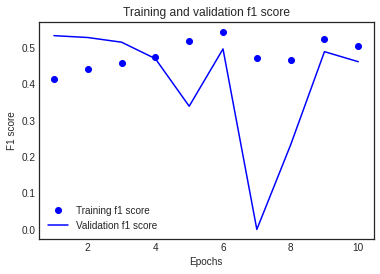

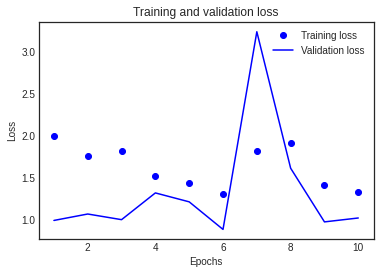

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_16 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_16 (Dropout)        (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=6, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/6
42/42 [==============================] - 13s 99ms/step - loss: 1.9919 - get_f1: 0.4047
Epoch 2/6
42/42 [==============================] - 4s 99ms/step - loss: 1.6297 - get_f1: 0.4416
Epoch 3/6
42/42 [==============================] - 4s 100ms/step - loss: 1.6118 - get_f1: 0.4277
Epoch 4/6
42/42 [==============================] - 4s 106ms/step - loss: 1.4661 - get_f1: 0.4981
Epoch 5/6
42/42 [==============================] - 4s 100ms/step - loss: 1.4788 - get_f1: 0.4632
Epoch 6/6
42/42 [==============================] - 4s 101ms/step - loss: 1.2935 - get_f1: 0.5003
Training time: 50.34771466255188s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 5s 98ms/step - loss: 1.1084 - get_f1: 0.6429
train:  [1.1083595752716064, 0.6428554058074951]
11/11 [==============================] - 1s 94ms/step - loss: 1.2518 - get_f1: 0.6072
test:  [1.2518465518951416, 0.6071701645851135]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4574871085760378
AP macro:  0.4574871085760378 

f1 micro:  0.5476190476190477
f1 macro:  0.5337253040207428
f1 binary:  0.6142131979695431 

precision micro:  0.5476190476190477
precision macro:  0.6518007662835249
precision binary:  0.46360153256704983 

recall micro:  0.5476190476190477
recall macro:  0.6100596318382162
recall binary:  0.9097744360902256 

accuracy:  0.5476190476190477
log_loss:  1.25184650980815
brier_score_loss:  0.4523809523809524


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.31      0.45       203
           1       0.46      0.91      0.61       133

    accuracy                           0.55       336
   macro avg       0.65      0.61      0.53       336
weighted avg       0.69      0.55      0.52       336



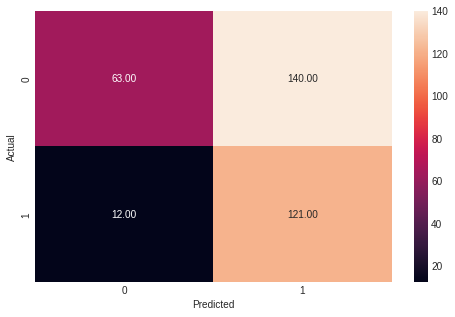

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.005 & bs=16 & do=0.2 - NIE

In [ ]:
learning_rate = 0.005
batch_size = 16

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)
X_val, y_val = X_test, y_test

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=15, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/15
84/84 [==============================] - 17s 100ms/step - loss: 1.4050 - get_f1: 0.3792 - val_loss: 0.7827 - val_get_f1: 0.4344
Epoch 2/15
84/84 [==============================] - 6s 69ms/step - loss: 1.0111 - get_f1: 0.4621 - val_loss: 0.7703 - val_get_f1: 0.5819
Epoch 3/15
84/84 [==============================] - 6s 69ms/step - loss: 0.9750 - get_f1: 0.4780 - val_loss: 0.7394 - val_get_f1: 0.4563
Epoch 4/15
84/84 [==============================] - 5s 65ms/step - loss: 0.9096 - get_f1: 0.5040 - val_loss: 0.7824 - val_get_f1: 0.4464
Epoch 5/15
84/84 [==============================] - 6s 69ms/step - loss: 0.8645 - get_f1: 0.5477 - val_loss: 0.7697 - val_get_f1: 0.5482
Epoch 6/15
84/84 [==============================] - 6s 69ms/step - loss: 0.8553 - get_f1: 0.5241 - val_loss: 1.2866 - val_get_f1: 0.5984
Epoch 7/15
84/84 [==============================] - 6s 66ms/step - loss: 0.9254 - get_f1: 0.5238 - val_loss: 0.7672 - val_get_f1: 0.5942
Epoch 8/15
84/84 [=====================

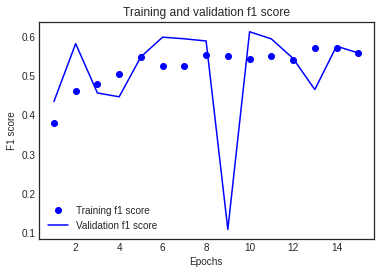

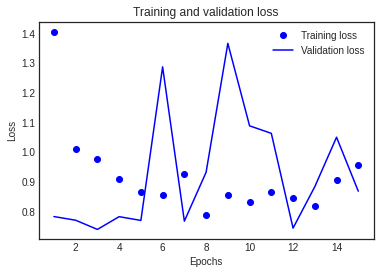

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=2, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/2
84/84 [==============================] - 15s 59ms/step - loss: 1.2824 - get_f1: 0.3883
Epoch 2/2
84/84 [==============================] - 5s 55ms/step - loss: 0.9845 - get_f1: 0.4410
Training time: 20.098939657211304s.


In [ ]:
y_pred_p = model.predict(X_test, batch_size=batch_size)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train, batch_size=batch_size))
  print('test: ', model.evaluate(X_test, y_test, batch_size=batch_size))

84/84 [==============================] - 6s 55ms/step - loss: 1.3263 - get_f1: 0.0986
train:  [1.3263155221939087, 0.09863515943288803]
21/21 [==============================] - 2s 56ms/step - loss: 1.4492 - get_f1: 0.0332
test:  [1.4491819143295288, 0.03318902850151062]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.40382205513784464
AP macro:  0.40382205513784464 

f1 micro:  0.6101190476190477
f1 macro:  0.3994679036769221
f1 binary:  0.043795620437956206 

precision micro:  0.6101190476190477
precision macro:  0.6792168674698795
precision binary:  0.75 

recall micro:  0.6101190476190477
recall macro:  0.5088151413015297
recall binary:  0.022556390977443608 

accuracy:  0.6101190476190477
log_loss:  1.4491819537962867
brier_score_loss:  0.3898809523809524


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       203
           1       0.75      0.02      0.04       133

    accuracy                           0.61       336
   macro avg       0.68      0.51      0.40       336
weighted avg       0.66      0.61      0.47       336



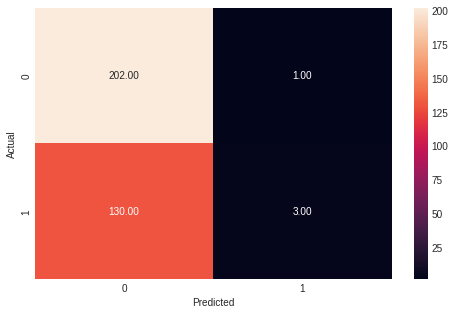

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001- NIE

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
##################################3 val=test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_20 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_20 (Dropout)        (None, 1280)              0         
                                                                 
 dense_20 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
##################################3 val=test
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
32/32 [==============================] - 11s 175ms/step - loss: 1.5970 - get_f1: 0.3928 - val_loss: 0.7338 - val_get_f1: 0.4357
Epoch 2/10
32/32 [==============================] - 4s 127ms/step - loss: 1.2786 - get_f1: 0.4658 - val_loss: 0.7606 - val_get_f1: 0.4307
Epoch 3/10
32/32 [==============================] - 4s 127ms/step - loss: 1.2371 - get_f1: 0.4893 - val_loss: 0.7576 - val_get_f1: 0.4523
Epoch 4/10
32/32 [==============================] - 4s 128ms/step - loss: 1.2002 - get_f1: 0.4826 - val_loss: 0.6908 - val_get_f1: 0.4404
Epoch 5/10
32/32 [==============================] - 4s 128ms/step - loss: 1.1482 - get_f1: 0.4907 - val_loss: 0.8934 - val_get_f1: 0.1573
Epoch 6/10
32/32 [==============================] - 4s 128ms/step - loss: 0.9818 - get_f1: 0.5110 - val_loss: 0.7478 - val_get_f1: 0.5443
Epoch 7/10
32/32 [==============================] - 4s 129ms/step - loss: 1.0623 - get_f1: 0.5113 - val_loss: 0.6970 - val_get_f1: 0.3604
Epoch 8/10
32/32 [===============

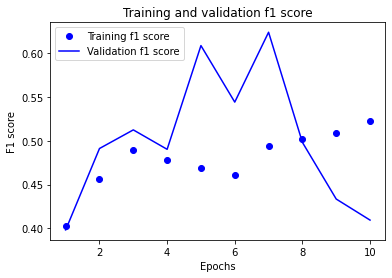

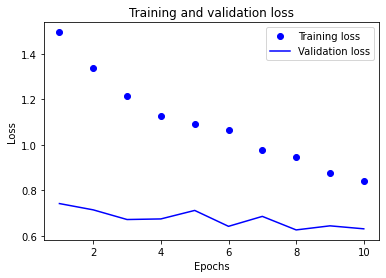

In [ ]:
##################################3 val=test
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

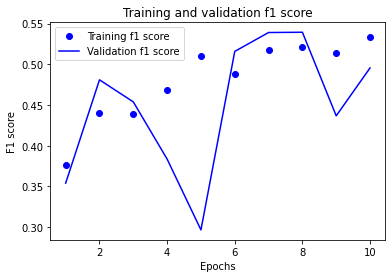

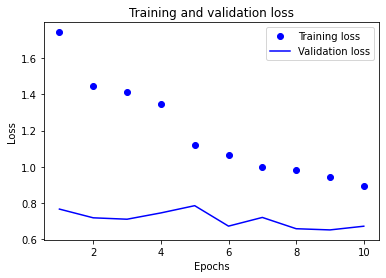

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_13 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_13 (Dropout)        (None, 1280)              0         
                                                                 
 dense_13 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=3, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
42/42 [==============================] - 15s 105ms/step - loss: 1.4465 - get_f1: 0.4040
Epoch 2/3
42/42 [==============================] - 4s 104ms/step - loss: 1.3933 - get_f1: 0.4252
Epoch 3/3
42/42 [==============================] - 4s 105ms/step - loss: 1.2339 - get_f1: 0.4455
Training time: 31.5800838470459s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4517820286009141
AP macro:  0.4517820286009141 

f1 micro:  0.6458333333333334
f1 macro:  0.5258907926720816
f1 binary:  0.2874251497005988 

precision micro:  0.6458333333333334
precision macro:  0.6724776003116479
precision binary:  0.7058823529411765 

recall micro:  0.6458333333333334
recall macro:  0.5655950220378532
recall binary:  0.18045112781954886 

accuracy:  0.6458333333333334
log_loss:  0.9216018031662001
brier_score_loss:  0.3541666666666667


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.95      0.76       203
           1       0.71      0.18      0.29       133

    accuracy                           0.65       336
   macro avg       0.67      0.57      0.53       336
weighted avg       0.67      0.65      0.58       336



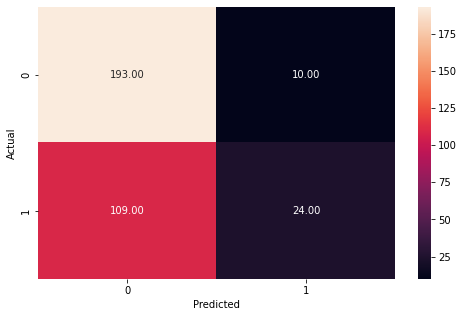

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.0001 & bs=16 - NIE

In [ ]:
learning_rate = 0.0001
batch_size = 16

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_11 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_11 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/20
63/63 [==============================] - 12s 96ms/step - loss: 1.6308 - get_f1: 0.3725 - val_loss: 0.7439 - val_get_f1: 0.3275
Epoch 2/20
63/63 [==============================] - 5s 72ms/step - loss: 1.5031 - get_f1: 0.3947 - val_loss: 0.7962 - val_get_f1: 0.1960
Epoch 3/20
63/63 [==============================] - 4s 71ms/step - loss: 1.5036 - get_f1: 0.3851 - val_loss: 0.7096 - val_get_f1: 0.3331
Epoch 4/20
63/63 [==============================] - 5s 75ms/step - loss: 1.3665 - get_f1: 0.4300 - val_loss: 0.6958 - val_get_f1: 0.4957
Epoch 5/20
63/63 [==============================] - 4s 71ms/step - loss: 1.4082 - get_f1: 0.4075 - val_loss: 0.6959 - val_get_f1: 0.3923
Epoch 6/20
63/63 [==============================] - 5s 72ms/step - loss: 1.3563 - get_f1: 0.4323 - val_loss: 0.6818 - val_get_f1: 0.4576
Epoch 7/20
63/63 [==============================] - 5s 72ms/step - loss: 1.3708 - get_f1: 0.4391 - val_loss: 0.6763 - val_get_f1: 0.5104
Epoch 8/20
63/63 [======================

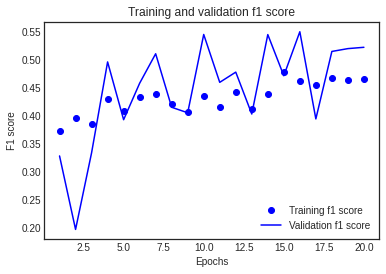

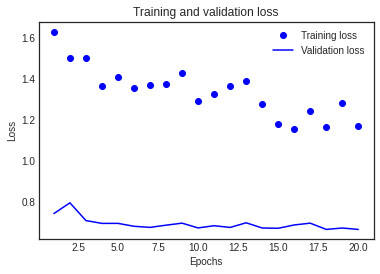

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_12 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=7, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/7
84/84 [==============================] - 13s 63ms/step - loss: 1.6973 - get_f1: 0.4439
Epoch 2/7
84/84 [==============================] - 5s 56ms/step - loss: 1.5008 - get_f1: 0.4005
Epoch 3/7
84/84 [==============================] - 5s 56ms/step - loss: 1.3867 - get_f1: 0.4398
Epoch 4/7
84/84 [==============================] - 5s 56ms/step - loss: 1.4272 - get_f1: 0.4227
Epoch 5/7
84/84 [==============================] - 5s 56ms/step - loss: 1.4505 - get_f1: 0.3892
Epoch 6/7
84/84 [==============================] - 5s 56ms/step - loss: 1.3649 - get_f1: 0.4193
Epoch 7/7
84/84 [==============================] - 5s 56ms/step - loss: 1.3923 - get_f1: 0.4446
Training time: 41.90586233139038s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 6s 99ms/step - loss: 0.8067 - get_f1: 0.3807
train:  [0.8067495822906494, 0.38069888949394226]
11/11 [==============================] - 1s 95ms/step - loss: 0.9109 - get_f1: 0.2917
test:  [0.910909116268158, 0.29172027111053467]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.41491228070175434
AP macro:  0.41491228070175434 

f1 micro:  0.5982142857142857
f1 macro:  0.50934048698173
f1 binary:  0.30051813471502586 

precision micro:  0.5982142857142857
precision macro:  0.5532608695652174
precision binary:  0.48333333333333334 

recall micro:  0.5982142857142857
recall macro:  0.5326678765880217
recall binary:  0.21804511278195488 

accuracy:  0.5982142857142857
log_loss:  0.9109090655770485
brier_score_loss:  0.4017857142857143


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.85      0.72       203
           1       0.48      0.22      0.30       133

    accuracy                           0.60       336
   macro avg       0.55      0.53      0.51       336
weighted avg       0.57      0.60      0.55       336



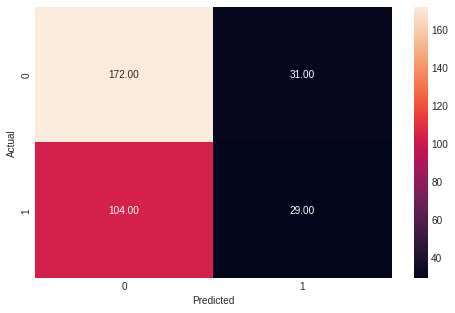

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 & bs=16 - NIE

In [ ]:
learning_rate = 0.001
batch_size = 16

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_19 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_19 (Dropout)        (None, 1280)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/20
63/63 [==============================] - 13s 122ms/step - loss: 1.6763 - get_f1: 0.4109 - val_loss: 1.0431 - val_get_f1: 0.1753
Epoch 2/20
63/63 [==============================] - 5s 73ms/step - loss: 1.3941 - get_f1: 0.4405 - val_loss: 0.9867 - val_get_f1: 0.2421
Epoch 3/20
63/63 [==============================] - 5s 74ms/step - loss: 1.3984 - get_f1: 0.4422 - val_loss: 0.7625 - val_get_f1: 0.4003
Epoch 4/20
63/63 [==============================] - 5s 73ms/step - loss: 1.2580 - get_f1: 0.4524 - val_loss: 0.7229 - val_get_f1: 0.4002
Epoch 5/20
63/63 [==============================] - 5s 73ms/step - loss: 1.0439 - get_f1: 0.5073 - val_loss: 0.6551 - val_get_f1: 0.5224
Epoch 6/20
63/63 [==============================] - 5s 73ms/step - loss: 1.1018 - get_f1: 0.4637 - val_loss: 0.6645 - val_get_f1: 0.4938
Epoch 7/20
63/63 [==============================] - 5s 77ms/step - loss: 0.9610 - get_f1: 0.4929 - val_loss: 0.6616 - val_get_f1: 0.4852
Epoch 8/20
63/63 [=====================

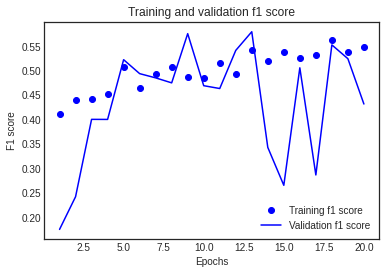

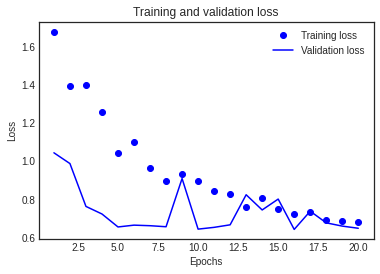

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_20 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_20 (Dropout)        (None, 1280)              0         
                                                                 
 dense_20 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/5
84/84 [==============================] - 15s 61ms/step - loss: 1.5628 - get_f1: 0.3805
Epoch 2/5
84/84 [==============================] - 5s 60ms/step - loss: 1.2321 - get_f1: 0.4189
Epoch 3/5
84/84 [==============================] - 5s 62ms/step - loss: 1.2673 - get_f1: 0.4284
Epoch 4/5
84/84 [==============================] - 5s 61ms/step - loss: 1.1078 - get_f1: 0.4155
Epoch 5/5
84/84 [==============================] - 5s 57ms/step - loss: 0.9688 - get_f1: 0.4804
Training time: 35.93200707435608s.


In [ ]:
y_pred_p = model.predict(X_test, batch_size=batch_size)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train, batch_size=batch_size))
  print('test: ', model.evaluate(X_test, y_test, batch_size=batch_size))

84/84 [==============================] - 6s 54ms/step - loss: 0.7222 - get_f1: 0.3380
train:  [0.7222433686256409, 0.3380035161972046]
21/21 [==============================] - 2s 55ms/step - loss: 0.8436 - get_f1: 0.2348
test:  [0.8435755372047424, 0.2347734123468399]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4320505210394407
AP macro:  0.4320505210394407 

f1 micro:  0.6279761904761905
f1 macro:  0.5097524249746122
f1 binary:  0.26900584795321636 

precision micro:  0.6279761904761905
precision macro:  0.6180678205581067
precision binary:  0.6052631578947368 

recall micro:  0.6279761904761905
recall macro:  0.549520352605652
recall binary:  0.17293233082706766 

accuracy:  0.6279761904761905
log_loss:  0.8435755501833184
brier_score_loss:  0.37202380952380953


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.93      0.75       203
           1       0.61      0.17      0.27       133

    accuracy                           0.63       336
   macro avg       0.62      0.55      0.51       336
weighted avg       0.62      0.63      0.56       336



In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.005 - NIE

In [ ]:
learning_rate = 0.005
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)
X_val, y_val = X_test, y_test

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/20
42/42 [==============================] - 17s 186ms/step - loss: 1.7258 - get_f1: 0.4103 - val_loss: 0.8523 - val_get_f1: 0.4559
Epoch 2/20
42/42 [==============================] - 5s 125ms/step - loss: 1.3330 - get_f1: 0.4527 - val_loss: 1.4249 - val_get_f1: 0.0228
Epoch 3/20
42/42 [==============================] - 5s 125ms/step - loss: 1.2324 - get_f1: 0.4572 - val_loss: 0.8076 - val_get_f1: 0.4139
Epoch 4/20
42/42 [==============================] - 5s 125ms/step - loss: 1.0937 - get_f1: 0.4779 - val_loss: 0.7349 - val_get_f1: 0.5434
Epoch 5/20
42/42 [==============================] - 5s 124ms/step - loss: 1.1219 - get_f1: 0.4732 - val_loss: 0.7402 - val_get_f1: 0.5784
Epoch 6/20
42/42 [==============================] - 5s 123ms/step - loss: 0.9878 - get_f1: 0.5036 - val_loss: 0.8110 - val_get_f1: 0.3656
Epoch 7/20
42/42 [==============================] - 5s 123ms/step - loss: 1.0560 - get_f1: 0.4879 - val_loss: 0.7364 - val_get_f1: 0.6228
Epoch 8/20
42/42 [===============

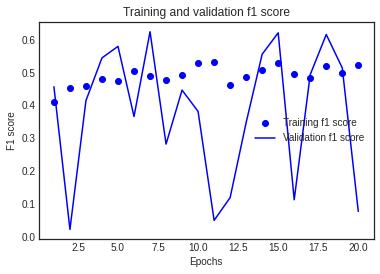

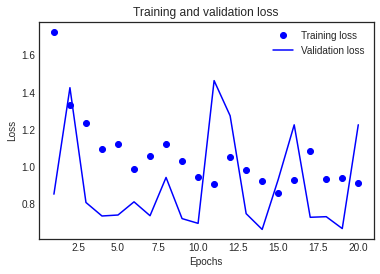

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_8 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=6, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/6
1340/1340 [==============================] - 20s 10ms/step - loss: 3.9646 - get_f1: 0.1903
Epoch 2/6
1340/1340 [==============================] - 14s 10ms/step - loss: 4.9431 - get_f1: 0.1843
Epoch 3/6
1340/1340 [==============================] - 14s 10ms/step - loss: 4.9984 - get_f1: 0.2022
Epoch 4/6
1340/1340 [==============================] - 15s 11ms/step - loss: 4.8577 - get_f1: 0.2000
Epoch 5/6
1340/1340 [==============================] - 14s 11ms/step - loss: 5.4300 - get_f1: 0.1933
Epoch 6/6
1340/1340 [==============================] - 14s 11ms/step - loss: 5.6764 - get_f1: 0.2030
Training time: 148.48522353172302s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 6s 99ms/step - loss: 6.4521 - get_f1: 0.6109
train:  [6.452149868011475, 0.6109282970428467]
11/11 [==============================] - 1s 94ms/step - loss: 7.5446 - get_f1: 0.5984
test:  [7.54461669921875, 0.5983998775482178]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.434594863447278
AP macro:  0.434594863447278 

f1 micro:  0.49404761904761907
f1 macro:  0.4567863664029215
f1 binary:  0.5990566037735849 

precision micro:  0.49404761904761907
precision macro:  0.6515463917525773
precision binary:  0.436426116838488 

recall micro:  0.49404761904761907
recall macro:  0.573502722323049
recall binary:  0.9548872180451128 

accuracy:  0.49404761904761907
log_loss:  nan
brier_score_loss:  0.5059523809523809


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [ ]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.87      0.19      0.31       203
           1       0.44      0.95      0.60       133

    accuracy                           0.49       336
   macro avg       0.65      0.57      0.46       336
weighted avg       0.70      0.49      0.43       336



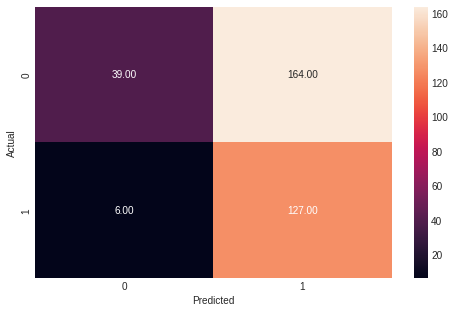

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.003 & do=0.2  - NIE

In [ ]:
learning_rate = 0.003
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)
X_val, y_val = X_test, y_test

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_9 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
42/42 [==============================] - 12s 160ms/step - loss: 1.2502 - get_f1: 0.3951 - val_loss: 1.1775 - val_get_f1: 0.2560
Epoch 2/10
42/42 [==============================] - 5s 125ms/step - loss: 0.9987 - get_f1: 0.4167 - val_loss: 0.8741 - val_get_f1: 0.3666
Epoch 3/10
42/42 [==============================] - 5s 127ms/step - loss: 0.9587 - get_f1: 0.4569 - val_loss: 1.1180 - val_get_f1: 0.5916
Epoch 4/10
42/42 [==============================] - 5s 126ms/step - loss: 0.8295 - get_f1: 0.5149 - val_loss: 0.6398 - val_get_f1: 0.5157
Epoch 5/10
42/42 [==============================] - 5s 125ms/step - loss: 0.7450 - get_f1: 0.5332 - val_loss: 0.7272 - val_get_f1: 0.6311
Epoch 6/10
42/42 [==============================] - 5s 124ms/step - loss: 0.7430 - get_f1: 0.5488 - val_loss: 0.6202 - val_get_f1: 0.5611
Epoch 7/10
42/42 [==============================] - 5s 125ms/step - loss: 0.6938 - get_f1: 0.5443 - val_loss: 0.6887 - val_get_f1: 0.4158
Epoch 8/10
42/42 [===============

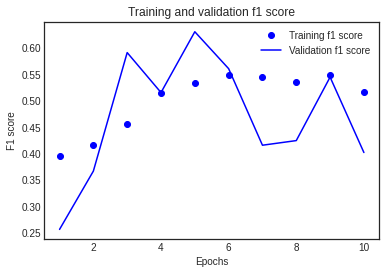

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_10 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=3, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
42/42 [==============================] - 17s 106ms/step - loss: 1.1279 - get_f1: 0.4043
Epoch 2/3
42/42 [==============================] - 4s 105ms/step - loss: 0.9280 - get_f1: 0.4731
Epoch 3/3
42/42 [==============================] - 4s 105ms/step - loss: 0.8452 - get_f1: 0.5126
Training time: 26.189967155456543s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 5s 97ms/step - loss: 0.6390 - get_f1: 0.4701
train:  [0.6389937996864319, 0.4701463282108307]
11/11 [==============================] - 1s 94ms/step - loss: 0.7852 - get_f1: 0.3685
test:  [0.7851805686950684, 0.36845675110816956]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4469478490747416
AP macro:  0.4469478490747416 

f1 micro:  0.6309523809523809
f1 macro:  0.5659819159131629
f1 binary:  0.3980582524271844 

precision micro:  0.6309523809523809
precision macro:  0.6059169748424398
precision binary:  0.5616438356164384 

recall micro:  0.6309523809523809
recall macro:  0.5753176043557169
recall binary:  0.3082706766917293 

accuracy:  0.6309523809523809
log_loss:  0.7851806098565465
brier_score_loss:  0.36904761904761907


In [ ]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       203
           1       0.56      0.31      0.40       133

    accuracy                           0.63       336
   macro avg       0.61      0.58      0.57       336
weighted avg       0.62      0.63      0.60       336



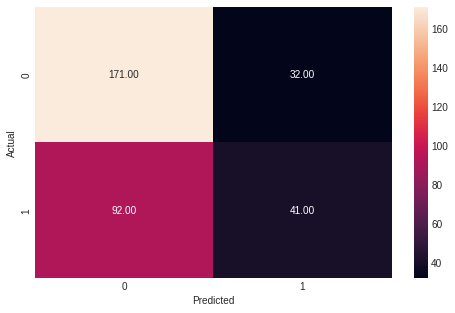

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.0001 // acc: 65, f1: 61, loss: 0.76 - NIE

In [ ]:
learning_rate = 0.0001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_22 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_22 (Dropout)        (None, 1280)              0         
                                                                 
 dense_22 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/25
32/32 [==============================] - 21s 254ms/step - loss: 1.5159 - get_f1: 0.3831 - val_loss: 0.8902 - val_get_f1: 0.3263
Epoch 2/25
32/32 [==============================] - 4s 137ms/step - loss: 1.6081 - get_f1: 0.3968 - val_loss: 0.8560 - val_get_f1: 0.2784
Epoch 3/25
32/32 [==============================] - 4s 137ms/step - loss: 1.5649 - get_f1: 0.3714 - val_loss: 0.8902 - val_get_f1: 0.1475
Epoch 4/25
32/32 [==============================] - 4s 137ms/step - loss: 1.6289 - get_f1: 0.3825 - val_loss: 0.7958 - val_get_f1: 0.3128
Epoch 5/25
32/32 [==============================] - 4s 133ms/step - loss: 1.5530 - get_f1: 0.4035 - val_loss: 0.7903 - val_get_f1: 0.3089
Epoch 6/25
32/32 [==============================] - 4s 130ms/step - loss: 1.3793 - get_f1: 0.4359 - val_loss: 0.7882 - val_get_f1: 0.3020
Epoch 7/25
32/32 [==============================] - 4s 131ms/step - loss: 1.4614 - get_f1: 0.4197 - val_loss: 0.7640 - val_get_f1: 0.3442
Epoch 8/25
32/32 [===============

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_23 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_23 (Dropout)        (None, 1280)              0         
                                                                 
 dense_23 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=7, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/7
42/42 [==============================] - 16s 104ms/step - loss: 1.6005 - get_f1: 0.3934
Epoch 2/7
42/42 [==============================] - 4s 104ms/step - loss: 1.4764 - get_f1: 0.3918
Epoch 3/7
42/42 [==============================] - 4s 106ms/step - loss: 1.4984 - get_f1: 0.3986
Epoch 4/7
42/42 [==============================] - 4s 107ms/step - loss: 1.4929 - get_f1: 0.4018
Epoch 5/7
42/42 [==============================] - 4s 107ms/step - loss: 1.4175 - get_f1: 0.3941
Epoch 6/7
42/42 [==============================] - 4s 105ms/step - loss: 1.3519 - get_f1: 0.4212
Epoch 7/7
42/42 [==============================] - 5s 107ms/step - loss: 1.2911 - get_f1: 0.4415
Training time: 53.10316228866577s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

  # e=15: loss: 0.7611 - get_f1: 0.4831
  # e=18: loss: 0.7744 - get_f1: 0.4140

42/42 [==============================] - 5s 96ms/step - loss: 0.7005 - get_f1: 0.5044
train:  [0.7005115747451782, 0.5044026970863342]
11/11 [==============================] - 2s 151ms/step - loss: 0.7744 - get_f1: 0.4140
test:  [0.7744322419166565, 0.41399136185646057]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4209482038429407
AP macro:  0.4209482038429407 

f1 micro:  0.5952380952380952
f1 macro:  0.5337713749336815
f1 binary:  0.3644859813084112 

precision micro:  0.5952380952380952
precision macro:  0.5564270152505446
precision binary:  0.48148148148148145 

recall micro:  0.5952380952380952
recall macro:  0.5431682654913145
recall binary:  0.2932330827067669 

accuracy:  0.5952380952380952
log_loss:  0.7743012699763876
brier_score_loss:  0.40476190476190477


In [ ]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       203
           1       0.48      0.29      0.36       133

    accuracy                           0.60       336
   macro avg       0.56      0.54      0.53       336
weighted avg       0.57      0.60      0.57       336



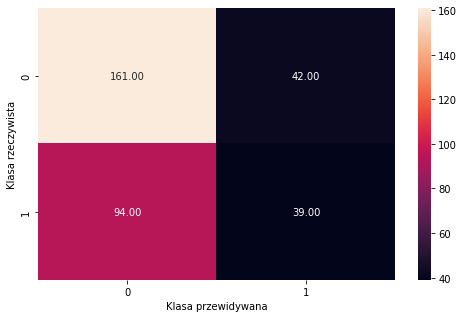

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

## lr=0.005 & do=0.2 // acc: 65, f1: 54, loss: 0.95 - NIE

In [ ]:
learning_rate = 0.005
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)
X_val, y_val = X_test, y_test

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
42/42 [==============================] - 26s 189ms/step - loss: 1.2544 - get_f1: 0.3962 - val_loss: 1.5985 - val_get_f1: 0.5681
Epoch 2/10
42/42 [==============================] - 5s 120ms/step - loss: 1.1190 - get_f1: 0.4288 - val_loss: 0.7755 - val_get_f1: 0.5312
Epoch 3/10
42/42 [==============================] - 5s 121ms/step - loss: 1.0340 - get_f1: 0.4550 - val_loss: 0.9798 - val_get_f1: 0.3238
Epoch 4/10
42/42 [==============================] - 5s 121ms/step - loss: 0.8765 - get_f1: 0.4965 - val_loss: 0.7046 - val_get_f1: 0.5914
Epoch 5/10
42/42 [==============================] - 5s 121ms/step - loss: 0.8132 - get_f1: 0.5340 - val_loss: 0.6955 - val_get_f1: 0.5951
Epoch 6/10
42/42 [==============================] - 5s 121ms/step - loss: 0.7757 - get_f1: 0.5553 - val_loss: 0.6615 - val_get_f1: 0.5432
Epoch 7/10
42/42 [==============================] - 5s 121ms/step - loss: 0.7081 - get_f1: 0.5375 - val_loss: 0.7272 - val_get_f1: 0.3835
Epoch 8/10
42/42 [===============

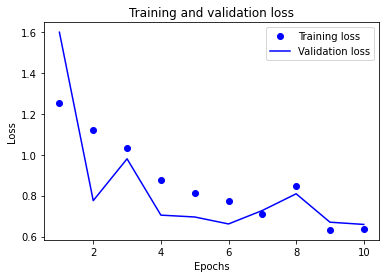

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=6, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/6
42/42 [==============================] - 13s 104ms/step - loss: 1.3175 - get_f1: 0.3570
Epoch 2/6
42/42 [==============================] - 4s 98ms/step - loss: 0.9259 - get_f1: 0.4855
Epoch 3/6
42/42 [==============================] - 4s 98ms/step - loss: 0.9713 - get_f1: 0.4636
Epoch 4/6
42/42 [==============================] - 4s 98ms/step - loss: 0.7864 - get_f1: 0.5091
Epoch 5/6
42/42 [==============================] - 4s 98ms/step - loss: 0.7271 - get_f1: 0.5433
Epoch 6/6
42/42 [==============================] - 4s 98ms/step - loss: 0.6843 - get_f1: 0.5542
Training time: 50.11932301521301s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

42/42 [==============================] - 6s 97ms/step - loss: 0.7180 - get_f1: 0.3733
train:  [0.7180188894271851, 0.37326279282569885]
11/11 [==============================] - 1s 96ms/step - loss: 0.9533 - get_f1: 0.2953
test:  [0.9532973170280457, 0.29530811309814453]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.463672574292875
AP macro:  0.463672574292875 

f1 micro:  0.6547619047619048
f1 macro:  0.5396825396825398
f1 binary:  0.30952380952380953 

precision micro:  0.6547619047619048
precision macro:  0.693687707641196
precision binary:  0.7428571428571429 

recall micro:  0.6547619047619048
recall macro:  0.5755768732175266
recall binary:  0.19548872180451127 

accuracy:  0.6547619047619048
log_loss:  0.9532972794133153
brier_score_loss:  0.34523809523809523


In [ ]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.64      0.96      0.77       203
           1       0.74      0.20      0.31       133

    accuracy                           0.65       336
   macro avg       0.69      0.58      0.54       336
weighted avg       0.68      0.65      0.59       336



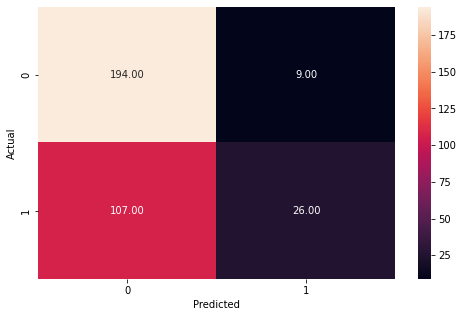

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.005 & bs=1 - ??? acc: 62, f1: 61, loss: 2.2 - NIE

In [ ]:
learning_rate = 0.005
batch_size = 1

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)
X_val, y_val = X_test, y_test

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_5 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/20
1340/1340 [==============================] - 33s 19ms/step - loss: 3.4877 - get_f1: 0.1806 - val_loss: 2.1840 - val_get_f1: 0.1488
Epoch 2/20
1340/1340 [==============================] - 19s 14ms/step - loss: 3.4217 - get_f1: 0.2007 - val_loss: 2.2799 - val_get_f1: 0.1458
Epoch 3/20
1340/1340 [==============================] - 17s 12ms/step - loss: 3.3940 - get_f1: 0.2112 - val_loss: 2.0616 - val_get_f1: 0.3036
Epoch 4/20
1340/1340 [==============================] - 19s 14ms/step - loss: 3.5948 - get_f1: 0.2201 - val_loss: 3.7220 - val_get_f1: 0.0506
Epoch 5/20
1340/1340 [==============================] - 18s 13ms/step - loss: 3.6042 - get_f1: 0.2209 - val_loss: 3.6581 - val_get_f1: 0.3482
Epoch 6/20
1340/1340 [==============================] - 17s 13ms/step - loss: 3.4721 - get_f1: 0.2187 - val_loss: 2.0763 - val_get_f1: 0.2381
Epoch 7/20
 226/1340 [====>.........................] - ETA: 14s - loss: 3.3459 - get_f1: 0.2699

KeyboardInterrupt: ignored

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_6 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=3, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
1340/1340 [==============================] - 51s 10ms/step - loss: 3.1414 - get_f1: 0.1813
Epoch 2/3
1340/1340 [==============================] - 16s 12ms/step - loss: 3.6075 - get_f1: 0.1955
Epoch 3/3
1340/1340 [==============================] - 16s 12ms/step - loss: 3.3891 - get_f1: 0.2097
Training time: 119.78885531425476s.


In [ ]:
y_pred_p = model.predict(X_test, batch_size=batch_size)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train, batch_size=batch_size))
  print('test: ', model.evaluate(X_test, y_test, batch_size=batch_size))

1340/1340 [==============================] - 14s 10ms/step - loss: 1.5941 - get_f1: 0.2619
train:  [1.5941448211669922, 0.26194027066230774]
336/336 [==============================] - 3s 10ms/step - loss: 2.2088 - get_f1: 0.2232
test:  [2.2088265419006348, 0.2232142686843872]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.46632205513784464
AP macro:  0.46632205513784464 

f1 micro:  0.6220238095238095
f1 macro:  0.6099986290727962
f1 binary:  0.5415162454873647 

precision micro:  0.6220238095238095
precision macro:  0.609375
precision binary:  0.5208333333333334 

recall micro:  0.6220238095238095
recall macro:  0.612004148301789
recall binary:  0.5639097744360902 

accuracy:  0.6220238095238095
log_loss:  nan
brier_score_loss:  0.37797619047619047


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [ ]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       203
           1       0.52      0.56      0.54       133

    accuracy                           0.62       336
   macro avg       0.61      0.61      0.61       336
weighted avg       0.63      0.62      0.62       336



In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.00005 // acc: 62, f1: 56, loss: 0.79 - NIE

In [ ]:
learning_rate = 0.00005
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_18 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_18 (Dropout)        (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/25
32/32 [==============================] - 16s 223ms/step - loss: 1.5892 - get_f1: 0.3794 - val_loss: 0.8361 - val_get_f1: 0.2843
Epoch 2/25
32/32 [==============================] - 4s 138ms/step - loss: 1.4831 - get_f1: 0.3934 - val_loss: 0.8194 - val_get_f1: 0.2990
Epoch 3/25
32/32 [==============================] - 4s 136ms/step - loss: 1.5532 - get_f1: 0.3537 - val_loss: 0.7911 - val_get_f1: 0.3733
Epoch 4/25
32/32 [==============================] - 4s 137ms/step - loss: 1.4487 - get_f1: 0.3937 - val_loss: 0.7800 - val_get_f1: 0.3119
Epoch 5/25
32/32 [==============================] - 4s 128ms/step - loss: 1.4641 - get_f1: 0.3971 - val_loss: 0.7706 - val_get_f1: 0.3226
Epoch 6/25
32/32 [==============================] - 4s 127ms/step - loss: 1.4598 - get_f1: 0.3882 - val_loss: 0.7573 - val_get_f1: 0.3651
Epoch 7/25
32/32 [==============================] - 4s 137ms/step - loss: 1.5097 - get_f1: 0.3896 - val_loss: 0.7479 - val_get_f1: 0.3856
Epoch 8/25
32/32 [===============

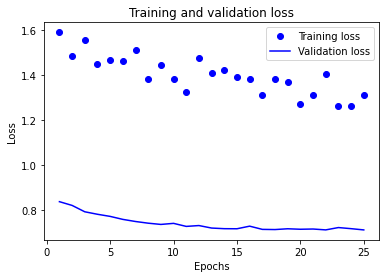

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_19 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_19 (Dropout)        (None, 1280)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=9, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/9
42/42 [==============================] - 15s 105ms/step - loss: 1.8090 - get_f1: 0.4743
Epoch 2/9
42/42 [==============================] - 4s 104ms/step - loss: 1.6016 - get_f1: 0.4110
Epoch 3/9
42/42 [==============================] - 4s 105ms/step - loss: 1.5808 - get_f1: 0.4259
Epoch 4/9
42/42 [==============================] - 4s 106ms/step - loss: 1.5441 - get_f1: 0.4003
Epoch 5/9
42/42 [==============================] - 4s 107ms/step - loss: 1.5202 - get_f1: 0.4097
Epoch 6/9
42/42 [==============================] - 4s 105ms/step - loss: 1.5128 - get_f1: 0.4197
Epoch 7/9
42/42 [==============================] - 4s 100ms/step - loss: 1.5075 - get_f1: 0.4186
Epoch 8/9
42/42 [==============================] - 4s 99ms/step - loss: 1.5628 - get_f1: 0.3962
Epoch 9/9
42/42 [==============================] - 4s 99ms/step - loss: 1.5028 - get_f1: 0.4002
Training time: 51.33745241165161s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4408738191632928
AP macro:  0.4408738191632928 

f1 micro:  0.6220238095238095
f1 macro:  0.5613080979942635
f1 binary:  0.3981042654028436 

precision micro:  0.6220238095238095
precision macro:  0.5928741800834825
precision binary:  0.5384615384615384 

recall micro:  0.6220238095238095
recall macro:  0.5692247861031889
recall binary:  0.3157894736842105 

accuracy:  0.6220238095238095
log_loss:  0.7857131824455879
brier_score_loss:  0.37797619047619047


In [ ]:
print(classification_report(y_test, y_pred))  

              precision    recall  f1-score   support

           0       0.65      0.82      0.72       203
           1       0.54      0.32      0.40       133

    accuracy                           0.62       336
   macro avg       0.59      0.57      0.56       336
weighted avg       0.60      0.62      0.60       336



## lr=0.0001 & do=0,2 - ??? //  acc: 62, f1: 59, loss: 0.68

In [ ]:
learning_rate = 0.0001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_16 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_16 (Dropout)        (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=23, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/23
32/32 [==============================] - 16s 234ms/step - loss: 1.1123 - get_f1: 0.3774 - val_loss: 0.9129 - val_get_f1: 0.3832
Epoch 2/23
32/32 [==============================] - 4s 137ms/step - loss: 1.1603 - get_f1: 0.3951 - val_loss: 0.8899 - val_get_f1: 0.4244
Epoch 3/23
32/32 [==============================] - 4s 135ms/step - loss: 1.0814 - get_f1: 0.4240 - val_loss: 0.8612 - val_get_f1: 0.4044
Epoch 4/23
32/32 [==============================] - 4s 127ms/step - loss: 1.0740 - get_f1: 0.3873 - val_loss: 0.8513 - val_get_f1: 0.4581
Epoch 5/23
32/32 [==============================] - 4s 138ms/step - loss: 1.0174 - get_f1: 0.4463 - val_loss: 0.8279 - val_get_f1: 0.4408
Epoch 6/23
32/32 [==============================] - 4s 127ms/step - loss: 1.0628 - get_f1: 0.4090 - val_loss: 0.8159 - val_get_f1: 0.4468
Epoch 7/23
32/32 [==============================] - 4s 138ms/step - loss: 1.0328 - get_f1: 0.4272 - val_loss: 0.8100 - val_get_f1: 0.4770
Epoch 8/23
32/32 [===============

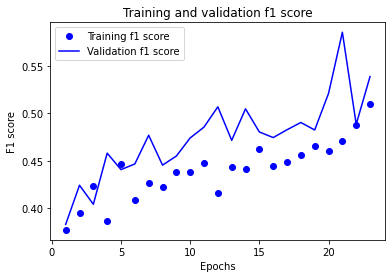

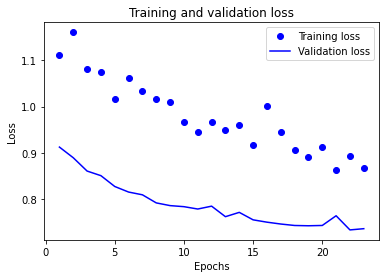

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_24 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_24 (Dropout)        (None, 1280)              0         
                                                                 
 dense_24 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=11, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/11
42/42 [==============================] - 10s 97ms/step - loss: 1.2106 - get_f1: 0.3485
Epoch 2/11
42/42 [==============================] - 4s 97ms/step - loss: 1.0204 - get_f1: 0.3844
Epoch 3/11
42/42 [==============================] - 4s 97ms/step - loss: 1.1065 - get_f1: 0.3824
Epoch 4/11
42/42 [==============================] - 4s 97ms/step - loss: 0.9785 - get_f1: 0.4105
Epoch 5/11
42/42 [==============================] - 4s 97ms/step - loss: 1.0452 - get_f1: 0.3756
Epoch 6/11
42/42 [==============================] - 4s 97ms/step - loss: 0.9376 - get_f1: 0.4270
Epoch 7/11
42/42 [==============================] - 4s 97ms/step - loss: 0.9514 - get_f1: 0.4324
Epoch 8/11
42/42 [==============================] - 4s 97ms/step - loss: 0.9901 - get_f1: 0.4349
Epoch 9/11
42/42 [==============================] - 4s 101ms/step - loss: 0.9137 - get_f1: 0.4295
Epoch 10/11
42/42 [==============================] - 4s 98ms/step - loss: 0.9683 - get_f1: 0.4201
Epoch 11/11
42/42 [========

In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.468057520037718
AP macro:  0.468057520037718 

f1 micro:  0.6428571428571429
f1 macro:  0.6066034422198805
f1 binary:  0.48717948717948717 

precision micro:  0.6428571428571429
precision macro:  0.6204760901622077
precision binary:  0.5643564356435643 

recall micro:  0.6428571428571429
recall macro:  0.6059113300492611
recall binary:  0.42857142857142855 

accuracy:  0.6428571428571429
log_loss:  0.7133067192309162
brier_score_loss:  0.35714285714285715


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73       203
           1       0.56      0.43      0.49       133

    accuracy                           0.64       336
   macro avg       0.62      0.61      0.61       336
weighted avg       0.63      0.64      0.63       336



In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 & do=0.2 ??? // acc: 61, f1: 59, loss: 0.73 - SELECTED

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)
X_val, y_val = X_test, y_test


In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_27 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_27 (Dropout)        (None, 1280)              0         
                                                                 
 dense_27 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
#with tf.device("/device:GPU:0"):
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 11s 176ms/step - loss: 1.5843 - get_f1: 0.3248 - val_loss: 0.9137 - val_get_f1: 0.2501
Epoch 2/10
32/32 [==============================] - 4s 129ms/step - loss: 1.0700 - get_f1: 0.4330 - val_loss: 0.7630 - val_get_f1: 0.4321
Epoch 3/10
32/32 [==============================] - 4s 129ms/step - loss: 0.9032 - get_f1: 0.4797 - val_loss: 0.7693 - val_get_f1: 0.5046
Epoch 4/10
32/32 [==============================] - 4s 128ms/step - loss: 0.9451 - get_f1: 0.4762 - val_loss: 0.7048 - val_get_f1: 0.4836
Epoch 5/10
32/32 [==============================] - 4s 129ms/step - loss: 0.8740 - get_f1: 0.4883 - val_loss: 0.6981 - val_get_f1: 0.4932
Epoch 6/10
32/32 [==============================] - 4s 133ms/step - loss: 0.8304 - get_f1: 0.5221 - val_loss: 0.7393 - val_get_f1: 0.3764
Epoch 7/10
32/32 [==============================] - 4s 131ms/step - loss: 0.7543 - get_f1: 0.5680 - val_loss: 0.6895 - val_get_f1: 0.4489
Epoch 8/10
32/32 [===============

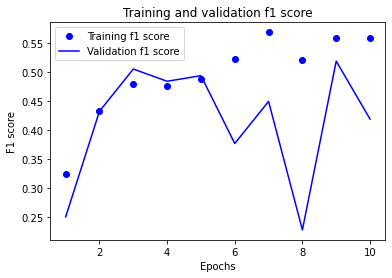

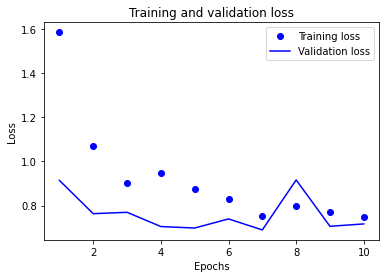

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/5
42/42 [==============================] - 21s 126ms/step - loss: 1.2034 - get_f1: 0.4043
Epoch 2/5
42/42 [==============================] - 4s 100ms/step - loss: 0.9696 - get_f1: 0.4785
Epoch 3/5
42/42 [==============================] - 4s 100ms/step - loss: 0.9421 - get_f1: 0.4545
Epoch 4/5
42/42 [==============================] - 4s 101ms/step - loss: 0.9281 - get_f1: 0.4593
Epoch 5/5
42/42 [==============================] - 4s 100ms/step - loss: 0.9149 - get_f1: 0.4747
Training time: 52.11937952041626s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test)) # e=6 loss: 0.6482 - get_f1: 0.5007

42/42 [==============================] - 7s 106ms/step - loss: 0.6367 - get_f1: 0.4585
train:  [0.6366941332817078, 0.45851507782936096]
11/11 [==============================] - 1s 100ms/step - loss: 0.6946 - get_f1: 0.4060
test:  [0.6945663094520569, 0.4060010612010956]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.4723020787262273
AP macro:  0.4723020787262273 

f1 micro:  0.6577380952380952
f1 macro:  0.5918496688531864
f1 binary:  0.42786069651741293 

precision micro:  0.6577380952380952
precision macro:  0.6482660228270413
precision binary:  0.6323529411764706 

recall micro:  0.6577380952380952
recall macro:  0.6000777806585429
recall binary:  0.3233082706766917 

accuracy:  0.6577380952380952
log_loss:  0.6945663374881406
brier_score_loss:  0.34226190476190477


In [ ]:
print(classification_report(y_test, y_pred))  

              precision    recall  f1-score   support

           0       0.66      0.88      0.76       203
           1       0.63      0.32      0.43       133

    accuracy                           0.66       336
   macro avg       0.65      0.60      0.59       336
weighted avg       0.65      0.66      0.63       336



In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model.save('drive/MyDrive/mgr/saved_models/4m_ef0_img_imbalanced_rp')

In [ ]:
test_model = models.load_model('drive/MyDrive/mgr/saved_models/4m_ef0_img_imbalanced_rp', custom_objects={"get_f1": get_f1})

In [ ]:
print(classification_report(y_test, test_model.predict(X_test)>=0.5))


              precision    recall  f1-score   support

           0       0.66      0.88      0.76       203
           1       0.63      0.32      0.43       133

    accuracy                           0.66       336
   macro avg       0.65      0.60      0.59       336
weighted avg       0.65      0.66      0.63       336



In [ ]:
y_pred_p = test_model.predict(X_test)
y_pred = y_pred_p>=0.5 

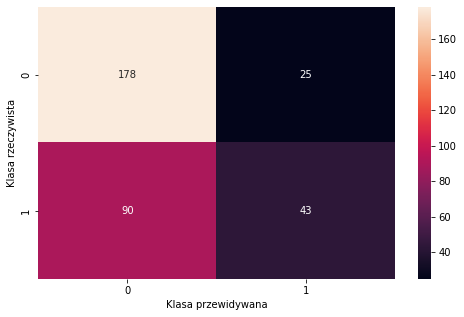

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

## lr=0.003 //  acc: 63, f1: 63, loss: 0.69 ???

In [ ]:
learning_rate = 0.003
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)
X_val, y_val = X_test, y_test

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
42/42 [==============================] - 13s 158ms/step - loss: 1.8721 - get_f1: 0.3834 - val_loss: 1.4330 - val_get_f1: 0.5904
Epoch 2/10
42/42 [==============================] - 5s 123ms/step - loss: 1.3359 - get_f1: 0.4497 - val_loss: 0.7115 - val_get_f1: 0.5329
Epoch 3/10
42/42 [==============================] - 5s 125ms/step - loss: 1.0840 - get_f1: 0.4929 - val_loss: 1.1770 - val_get_f1: 0.1978
Epoch 4/10
42/42 [==============================] - 5s 125ms/step - loss: 1.1347 - get_f1: 0.4671 - val_loss: 0.7822 - val_get_f1: 0.3890
Epoch 5/10
42/42 [==============================] - 5s 124ms/step - loss: 0.9138 - get_f1: 0.5165 - val_loss: 0.6727 - val_get_f1: 0.4944
Epoch 6/10
42/42 [==============================] - 5s 123ms/step - loss: 0.8941 - get_f1: 0.4985 - val_loss: 0.7124 - val_get_f1: 0.4613
Epoch 7/10
42/42 [==============================] - 5s 124ms/step - loss: 0.9353 - get_f1: 0.4746 - val_loss: 0.6931 - val_get_f1: 0.5820
Epoch 8/10
42/42 [===============

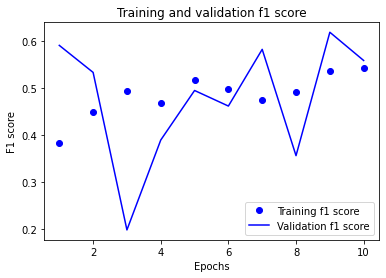

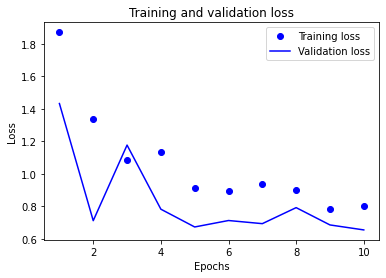

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_26 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_26 (Dropout)        (None, 1280)              0         
                                                                 
 dense_26 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/5
42/42 [==============================] - 11s 98ms/step - loss: 1.6383 - get_f1: 0.4181
Epoch 2/5
42/42 [==============================] - 4s 98ms/step - loss: 1.2805 - get_f1: 0.4568
Epoch 3/5
42/42 [==============================] - 4s 97ms/step - loss: 1.0691 - get_f1: 0.4626
Epoch 4/5
42/42 [==============================] - 4s 98ms/step - loss: 1.0638 - get_f1: 0.4714
Epoch 5/5
42/42 [==============================] - 4s 100ms/step - loss: 0.8945 - get_f1: 0.5306
Training time: 48.1028790473938s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.47086971460910343
AP macro:  0.47086971460910343 

f1 micro:  0.6488095238095238
f1 macro:  0.60665105758165
f1 binary:  0.47787610619469023 

precision micro:  0.6488095238095238
precision macro:  0.6277711403159432
precision binary:  0.5806451612903226 

recall micro:  0.6488095238095238
recall macro:  0.6069484054964999
recall binary:  0.40601503759398494 

accuracy:  0.6488095238095238
log_loss:  0.6803816517534452
brier_score_loss:  0.35119047619047616


In [ ]:
print(classification_report(y_test, y_pred))  

              precision    recall  f1-score   support

           0       0.67      0.81      0.74       203
           1       0.58      0.41      0.48       133

    accuracy                           0.65       336
   macro avg       0.63      0.61      0.61       336
weighted avg       0.64      0.65      0.63       336



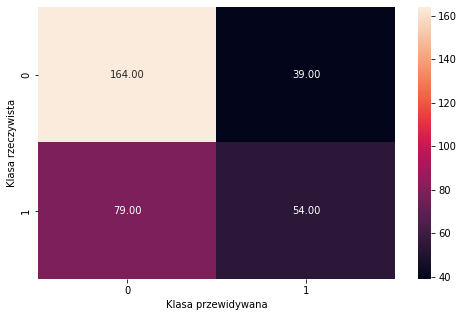

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)